In [59]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [60]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [61]:
NUM_CLASSES = 12

# 入力長

In [62]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [63]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [64]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [66]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [67]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 24)                792       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                250       
                                                                 
 dense_11 (Dense)            (None, 12)                132       
                                                                 
Total params: 1,174
Trainable params: 1,174
Non-trainable params: 0
_________________________________________________________________


In [68]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [69]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [70]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


 1/32 [..............................] - ETA: 33s - loss: 2.4888 - accuracy: 0.0391
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 1s 9ms/step - loss: 2.4541 - accuracy: 0.2559 - val_loss: 2.4138 - val_accuracy: 0.3276
Epoch 2/1000
 1/32 [..............................] - ETA: 0s - loss: 2.4185 - accuracy: 0.3047
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 4ms/step - loss: 2.3686 - accuracy: 0.2874 - val_loss: 2.3112 - val_accuracy: 0.3381
Epoch 3/1000
 1/32 [..............................] - ETA: 0s - loss: 2.2940 - accuracy: 0.2578
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 3ms/step - loss: 2.2440 - accuracy: 0.2832 - val_loss: 2.1506 - val_accuracy: 0.3411
Epoch 4/1000
 1/32 [..............................] - ETA: 0s - loss: 2.1838 - 

In [71]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [72]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 106ms/step
[9.6005791e-01 9.1757039e-03 1.8846607e-02 1.0802588e-02 4.6703747e-07
 1.1149840e-03 3.9167921e-07 1.5457208e-07 2.5939821e-07 3.2697730e-07
 2.1756908e-07 3.1874106e-07]
0


# 混同行列

42/42 [==============================] - 0s 3ms/step


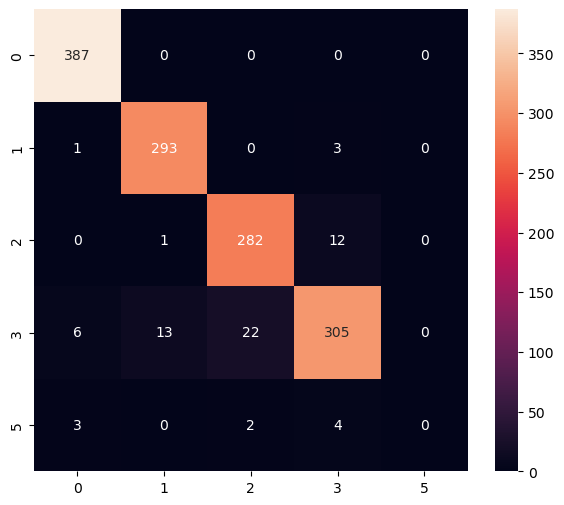

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       387
           1       0.95      0.99      0.97       297
           2       0.92      0.96      0.94       295
           3       0.94      0.88      0.91       346
           5       0.00      0.00      0.00         9

    accuracy                           0.95      1334
   macro avg       0.76      0.76      0.76      1334
weighted avg       0.94      0.95      0.95      1334



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [74]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [75]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [76]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2023-06-20 00:12:19.452628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?,32]
	 [[{{node input_4}}]]
2023-06-20 00:12:19.657370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-06-20 00:12:19.708909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?,32]
	 [[{{node input_4}}]]
2023-06-20 00:1

INFO:tensorflow:Assets written to: /tmp/tmpa6i7huka/assets


INFO:tensorflow:Assets written to: /tmp/tmpa6i7huka/assets
2023-06-20 00:12:22.651104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-20 00:12:22.651141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-20 00:12:22.651620: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa6i7huka
2023-06-20 00:12:22.652503: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-20 00:12:22.652541: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa6i7huka
2023-06-20 00:12:22.656101: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-20 00:12:22.679849: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpa6i7huka
2023-06-20 00:12:22.687329: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

6836

# 推論テスト

In [77]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [78]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [79]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [80]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 937 µs, sys: 0 ns, total: 937 µs
Wall time: 684 µs


In [81]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.6005791e-01 9.1756992e-03 1.8846607e-02 1.0802588e-02 4.6703747e-07
 1.1149836e-03 3.9167884e-07 1.5457192e-07 2.5939795e-07 3.2697668e-07
 2.1756865e-07 3.1874075e-07]
0
